Per L=1: Media della Loss = -0.08154+0.00000j, Varianza = 18.06293
Per L=2: Media della Loss = -0.04434-0.00000j, Varianza = 14.51768
Per L=3: Media della Loss = 0.05410+0.00000j, Varianza = 10.70165
Per L=4: Media della Loss = 0.07059-0.00000j, Varianza = 11.10446
Per L=5: Media della Loss = 0.01994+0.00000j, Varianza = 9.94582
Per L=6: Media della Loss = 0.03232-0.00000j, Varianza = 8.04970
Per L=7: Media della Loss = -0.04144+0.00000j, Varianza = 8.41779
Per L=8: Media della Loss = 0.00338-0.00000j, Varianza = 7.13280
Per L=9: Media della Loss = -0.09754+0.00000j, Varianza = 5.83494
Per L=10: Media della Loss = -0.07283-0.00000j, Varianza = 5.98134
Per L=11: Media della Loss = -0.06260+0.00000j, Varianza = 6.34935
Per L=12: Media della Loss = 0.00842+0.00000j, Varianza = 5.90126
Per L=13: Media della Loss = -0.01382+0.00000j, Varianza = 6.21453
Per L=14: Media della Loss = -0.12952-0.00000j, Varianza = 5.13723
Per L=15: Media della Loss = -0.02935-0.00000j, Varianza = 5.33866
Per L=

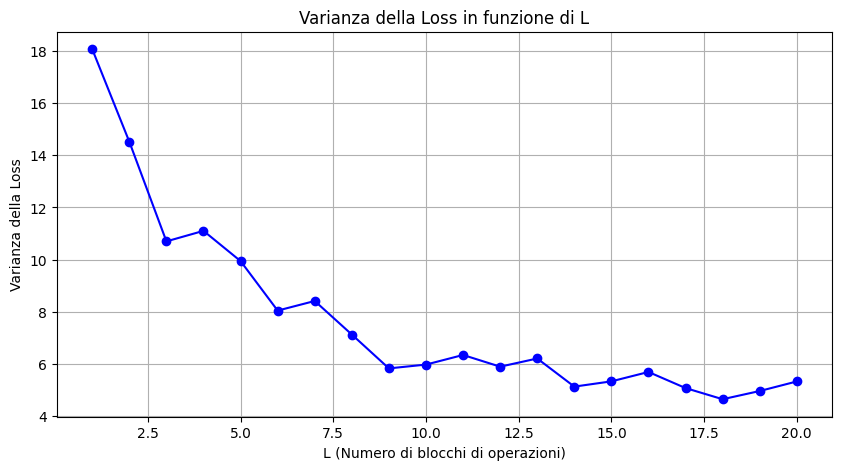

/Users/sebastianopian/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sebastianopian/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


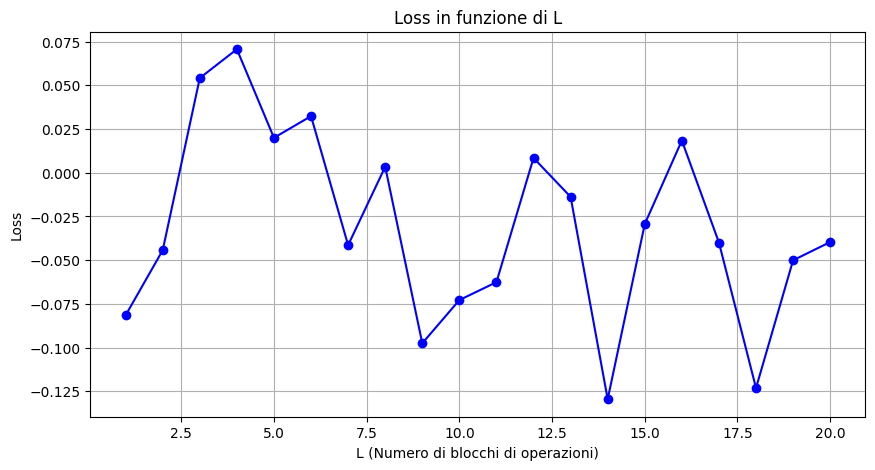

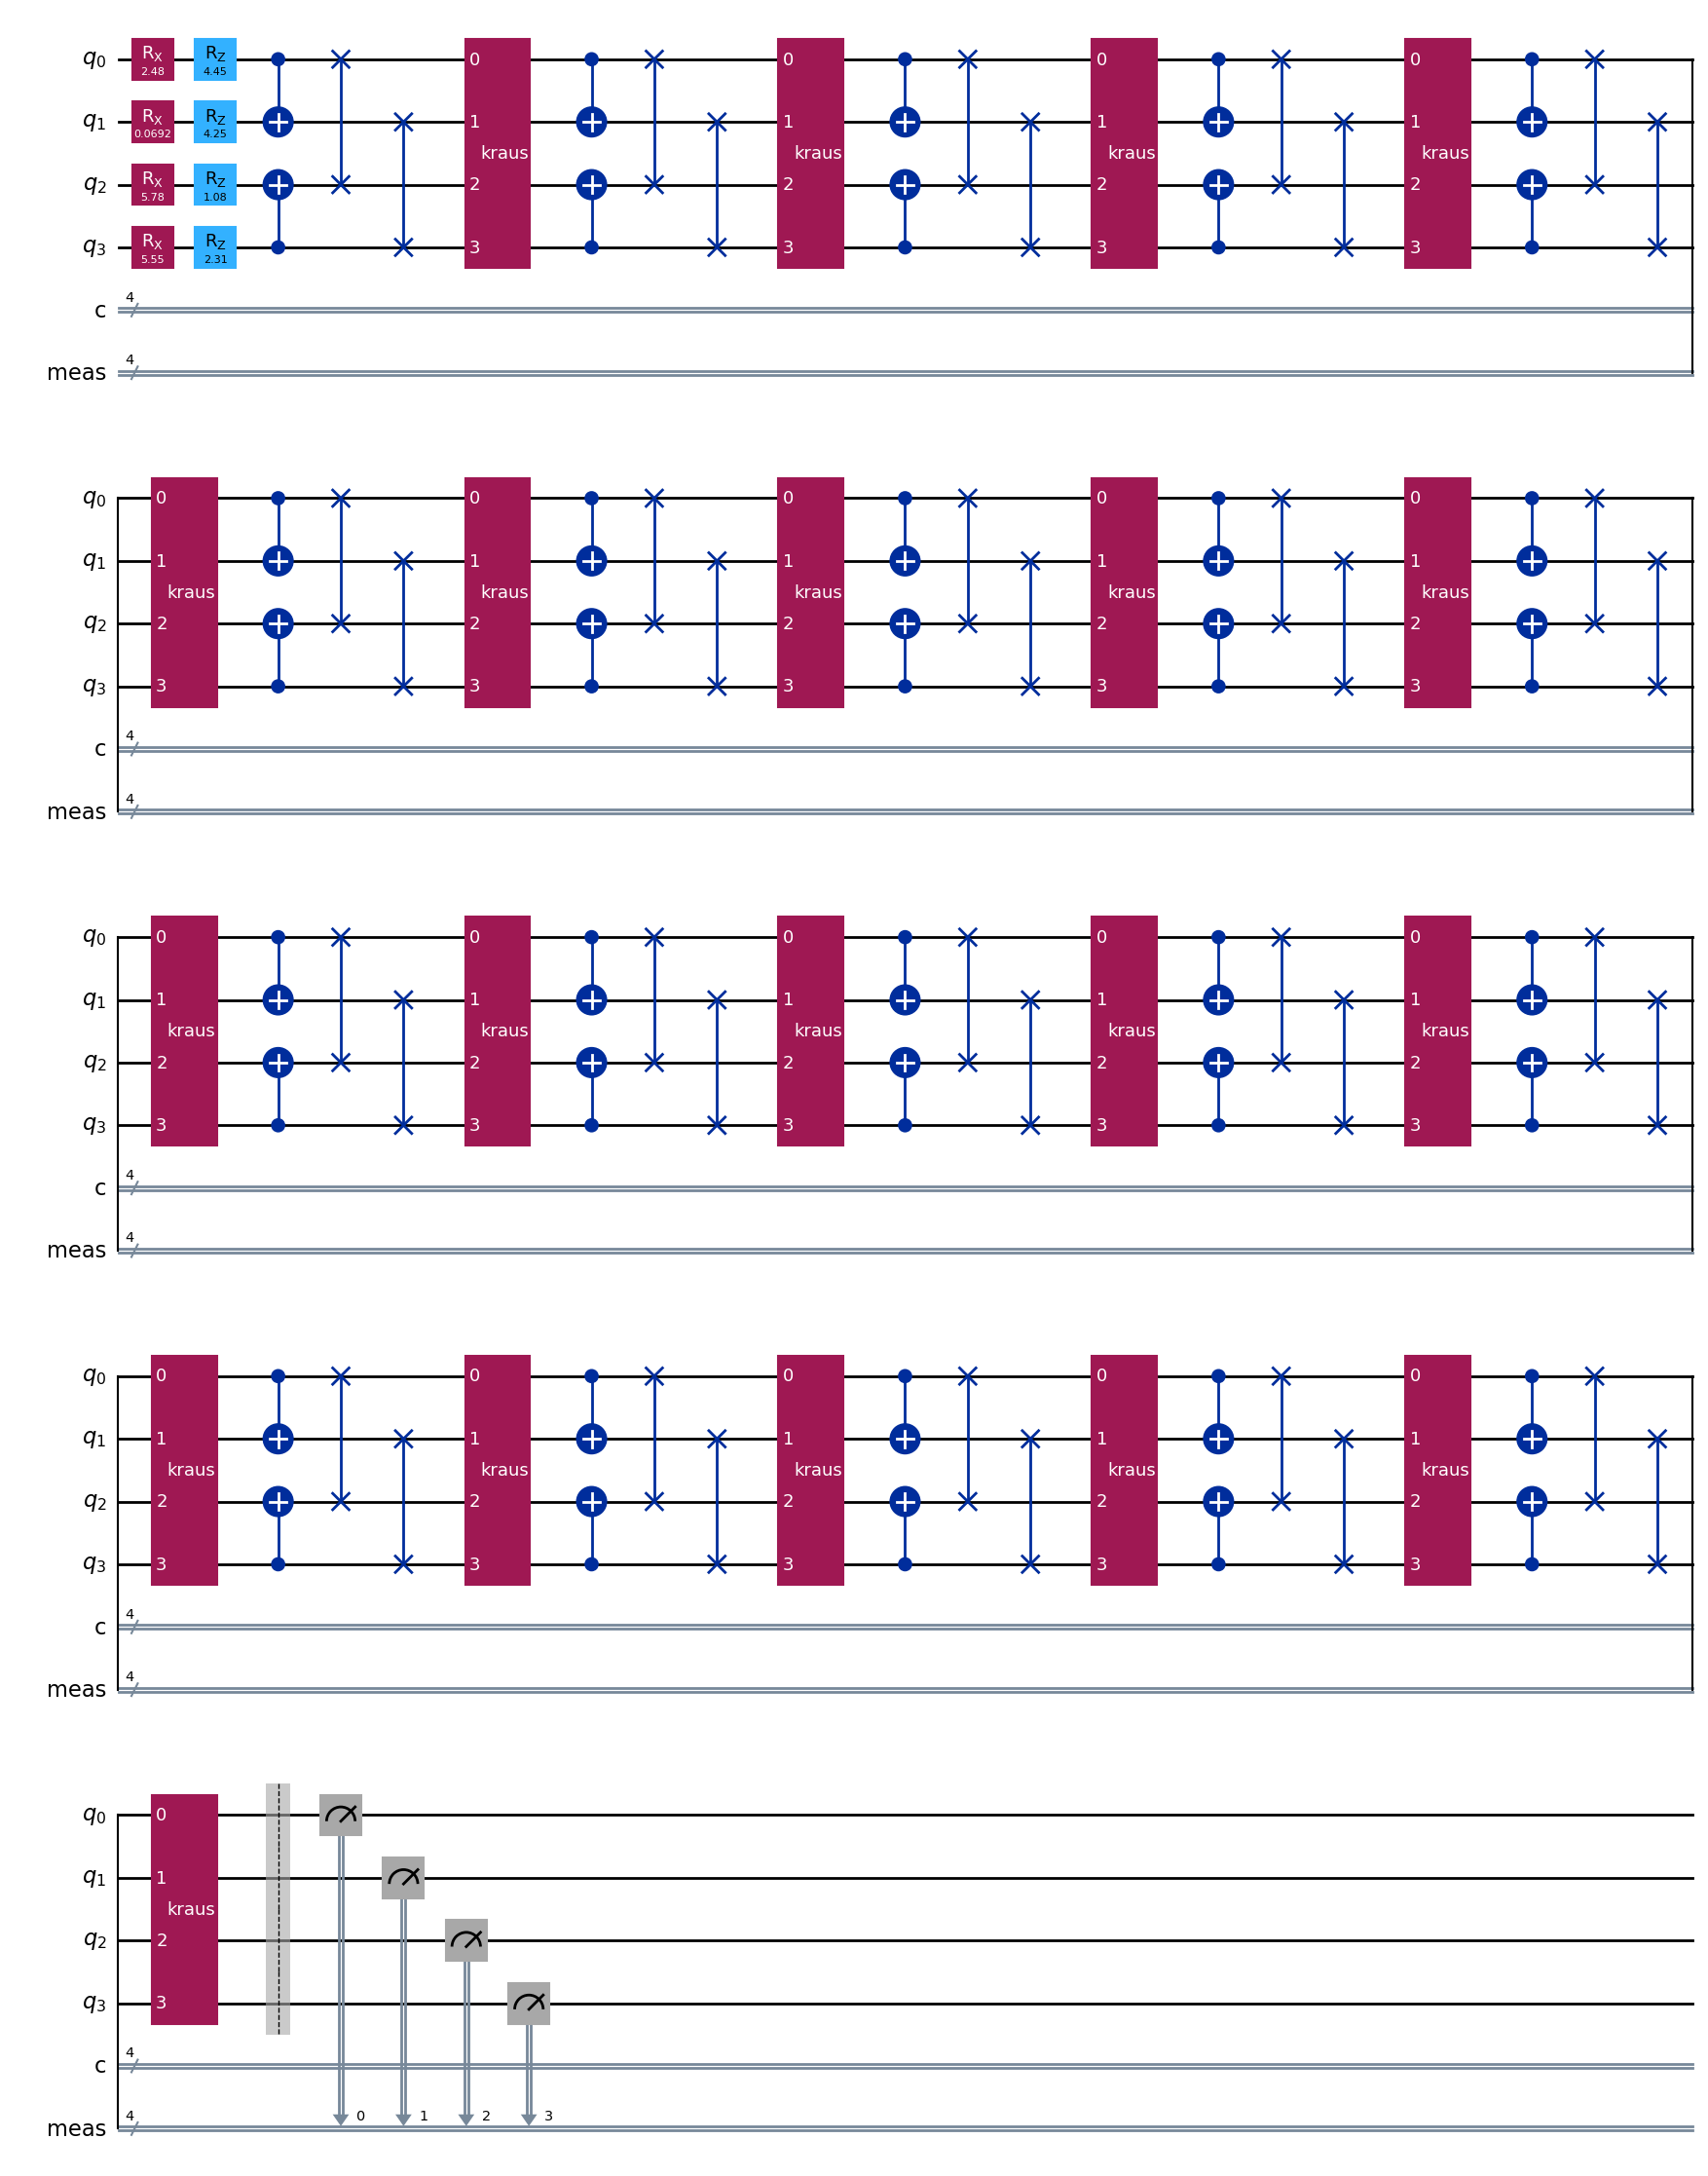

In [76]:
import qiskit as qc
from qiskit_aer import Aer
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, Kraus, Operator, SparsePauliOp
import matplotlib.pyplot as plt
from sympy import Matrix, latex, pretty_print


# Parametri
n = 4  # Numero di qubit
shots = 2000  # Numero di esecuzioni per ogni valore di L_values
L_values_range = 20  # Numero di blocchi di operazioni
p = 0.1  # Probabilità di applicare l'operatore di Kraus
h = 1  # Coefficiente nell'Hamiltoniano

def generate_random_parameters(n):
    return 2 * np.pi * np.random.rand(2 * n)

# Funzione per creare la catena di CNOT come circuito
def create_cnot_chain_circuit(n):
    cnot_circuit = QuantumCircuit(n)
    for i in range(n - 1):
        cnot_circuit.cx(i, i + 1)
    return cnot_circuit

# Costruzione della matrice per la catena di CNOT
cnot_circuit = create_cnot_chain_circuit(n)
cnot_operator = Operator(cnot_circuit)

# Definizione degli operatori di Kraus
I_n = np.eye(2**n)  # Identità su n qubit
K0 = np.sqrt(1 - p) * I_n
K1 = np.sqrt(p) * cnot_operator.data  # Matrice della catena di CNOT
kraus_channel = Kraus([K0, K1])  # Creazione del canale di Kraus

# Creazione di W (Hamiltoniano)
pauli_strings = []
coefficients = []

for k in range(n):
    coeff = h * 2**(n / 2)  # Coefficiente del termine
    coefficients.append(coeff)
    # Stringa di Pauli per Z_k ⊗ Z_{k+1}
    pauli_string = ['I'] * n
    pauli_string[k] = 'Z'  # Z_k
    pauli_string[(k + 1) % n] = 'Z'  # Z_{k+1} (periodico)
    pauli_strings.append("".join(pauli_string))

# Creazione dell'Hamiltoniano come SparsePauliOp
W = SparsePauliOp(pauli_strings, coeffs=np.array(coefficients))

# Simulatore
simulator = Aer.get_backend('aer_simulator')

# Lista per memorizzare i valori di L per ogni valore di L_values (da 1 a 6)
L_values_all = {L: [] for L in range(1, L_values_range + 1)}

# Esegui per ogni valore di L (da 1 a 6)
for L in range(1, L_values_range + 1):

    # Lista per memorizzare i valori di L per i 100 ripetizioni (shots)
    L_values_shots = []

    # Ripetizioni per ciascun L
    for _ in range(shots):

        qc = QuantumCircuit(n, n)

        # Genera parametri casuali per ogni iterazione
        parameters = generate_random_parameters(n)

        # Applica rotazioni
        for i in range(n):
            qc.rx(parameters[2 * i], i)
            qc.rz(parameters[2 * i + 1], i)

        # Applica L CNOT e swap (per ogni L_values specificato)
        for _ in range(L):
            qc.cx(0, 1)
            qc.cx(3, 2)
            qc.swap(0, 2)
            qc.swap(1, 3)

        # Applica il canale di Kraus
            qc.append(kraus_channel, list(range(n)))

        # Creazione della matrice densità finale
        rho = DensityMatrix.from_instruction(qc)
        W_matrix = W.to_matrix()

        qc.measure_all()

        # Calcola il valore di L per questo shot
        L_value = np.trace(np.dot(W_matrix, rho.data))

        # Aggiungi il valore di L per questo shot
        L_values_shots.append(L_value)

    # Aggiungi i valori di L per questo valore di L_values
    L_values_all[L] = L_values_shots

# Calcola la media e la varianza per ogni valore di L (da 1 a 6)
L_means = {L: np.mean(L_values_all[L]) for L in range(1, L_values_range + 1)}
L_variances = {L: np.var(L_values_all[L]) for L in range(1, L_values_range + 1)}

# Stampa i risultati
for L in range(1, L_values_range + 1):
    print(f"Per L={L}: Media della Loss = {L_means[L]:.5f}, Varianza = {L_variances[L]:.5f}")

# Plot della varianza in funzione di L
L_range = list(L_variances.keys())  # Intervallo di L (da 1 a 6)
var_values = list(L_variances.values())  # Valori di varianza corrispondenti
L_values = list(L_means.values())

plt.figure(figsize=(10, 5))  # Imposta la dimensione della figura
plt.plot(L_range, var_values, marker='o', linestyle='-', color='b')  # Grafico della varianza
plt.xlabel('L (Numero di blocchi di operazioni)')  # Etichetta asse x
plt.ylabel('Varianza della Loss')  # Etichetta asse y
plt.title('Varianza della Loss in funzione di L')  # Titolo del grafico
plt.grid(True)  # Aggiungi la griglia
plt.show()  # Mostra il grafico

plt.figure(figsize=(10, 5))  # Imposta la dimensione della figura
plt.plot(L_range, L_values, marker='o', linestyle='-', color='b')  # Grafico della varianza
plt.xlabel('L (Numero di blocchi di operazioni)')  # Etichetta asse x
plt.ylabel('Loss')  # Etichetta asse y
plt.title('Loss in funzione di L')  # Titolo del grafico
plt.grid(True)  # Aggiungi la griglia
plt.show()  # Mostra il grafico

qc.draw(output="mpl")